In [21]:
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import numpy as np
import datetime
import dask.dataframe as dd
import csv
import datetime as dt
from matplotlib.dates import DateFormatter

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score, cross_val_predict

from statsmodels.formula.api import ols
import seaborn as sn

import pathlib
import streamlit as st

cur_dir = pathlib.Path().parent.absolute()
#print(cur_dir)
plt.rcParams["figure.figsize"] = (18, 6)

In [22]:
locations = {
    "Galway/Mayo Coast": "_54_53.5_11_10.nc",
    "M1": "_53.5_53_12_11.nc",
    "M2": "_53.5_53_5.5_4.5.nc",
    "M3": "_51.5_51_11_10.nc",
    "M4": "_55.5_55_10_9.nc",
    "M5": "_52_51.5_7_6.nc"
     }

#m2 = locations["M2"]
#data_m2 = xr.open_dataset(str(cur_dir) + "/gis_data/MetO-NWS-WAV-RAN" + str(m2))

m3 = locations["M3"]
data_m3 = xr.open_dataset(str(cur_dir) + "/gis_data/MetO-NWS-WAV-RAN" + str(m3))

#m4 = locations["M4"]
#data_m4 = xr.open_dataset(str(cur_dir) + "/gis_data/MetO-NWS-WAV-RAN" + str(m4))

#m5 = locations["M5"]
#data_m5 = xr.open_dataset(str(cur_dir) + "/gis_data/MetO-NWS-WAV-RAN" + str(m5))

<br/>
<br/>
<br/>
<br/>

# Analysis of Data Satellite Data

In [23]:
data = xr.open_dataset(str(cur_dir) + "/gis_data/MetO-NWS-WAV-RAN_54_53.5_11_10.nc")
data

<xarray.Dataset>
Dimensions:    (time: 58440, latitude: 38, longitude: 34)
Coordinates:
  * latitude   (latitude) float32 53.5 53.51 53.53 53.54 ... 53.97 53.99 54.0
  * time       (time) datetime64[ns] 2000-01-01 ... 2019-12-31T21:00:00
  * longitude  (longitude) float32 -11.0 -10.97 -10.94 ... -10.06 -10.03 -10.0
Data variables:
    VTPK       (time, latitude, longitude) float32 ...
    crs        (time) int32 ...
    VHM0       (time, latitude, longitude) float32 ...
    VTM10      (time, latitude, longitude) float32 ...
Attributes:
    Conventions:          CF-1.7
    institution:          UK Met Office
    contact:              servicedesk.cmems@mercator-ocean.eu
    references:           http://marine.copernicus.eu/
    title:                3-hourly-instantaneous wave
    source:               Met Office Operational Suite, Atlantic Margin Model...
    forcing_data_source:  ECMWF; ERA-5"
    netcdf-version-id:    NETCDF4
    grid_id:              wave_nwshelf_standard_v1.1
    history:              File created: 2020-12-12T00:36:38Z
    _CoordSysBuilder:     ucar.nc2.dataset.conv.CF1Convention
    comment:

Text(0, 0.5, 'Wave Height (m)')

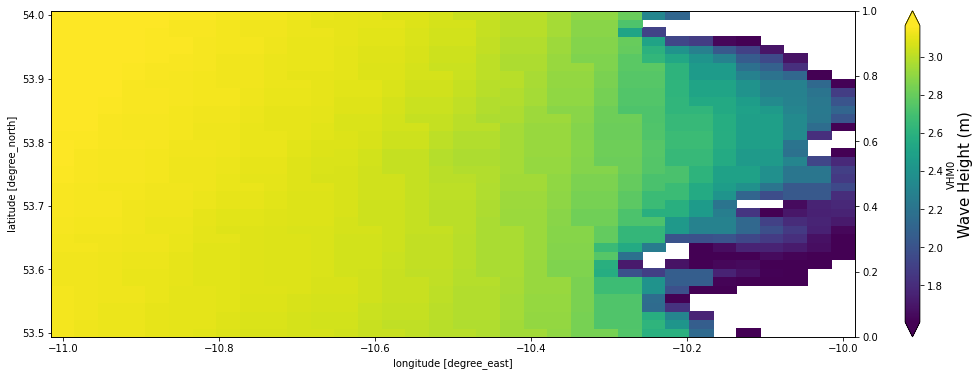

In [24]:
every_day = data["VHM0"].mean(dim = "time")
every_day.plot(robust = True)
plt.twinx().axes.yaxis.set_label_position("right")
plt.ylabel("Wave Height (m)", labelpad = 80, size = 15)

In [25]:
data = xr.open_dataset(str(cur_dir) + "/gis_data/MetO-NWS-WAV-RAN_51.5_51_11_10.nc")

In [26]:
def time_series(lat, long, start, finish):
    
    if type(lat) is float or type(lat) is int:
        ts = data["VHM0"].sel(latitude = lat, 
                          longitude = long, 
                          time = slice(start, finish))
        return ts
    
    
    elif type(lat) is tuple or type(lat) is tuple:
        ts = data["VHM0"].sel(latitude = slice(lat[0], lat[1]), 
                          longitude = slice(long[0], long[1]), 
                          time = slice(start, finish)
                          ).mean(dim = "longitude").mean(dim = "latitude")
        return ts

In [27]:
def make_plot(t1, t2):
    fig, ax = plt.subplots()
    count = 0
    for lat1 in data["VHM0"]["latitude"].values:
        lat1 = float(lat1)
        for long1 in data["VHM0"]["longitude"].values:
            long1 = float(long1)
        
            a1 = time_series(lat1, long1, t1,  t2)
            if a1 is not None:
                ax.plot(a1, color = "red", alpha = 0.07)
            else:
                count += 1

    plt.plot(a1, color = "red", label = "Value of wave height for each individual subcell")            
    print(count)
        
    ts = time_series((data["VHM0"]["latitude"][0], data["VHM0"]["latitude"][-1]), (data["VHM0"]["longitude"][0], data["VHM0"]["longitude"][-1]), t1, t2)        
    plt.plot(ts, color = "black", label = "Average value for wave height over entire cell")
    plt.legend(fontsize = 15)
    
    current_values = plt.gca().get_xticks()
    start_index = list(data["VHM0"]["time"].values).index(np.datetime64(t1))
    plt.gca().set_xticklabels([(pd.to_datetime(data["time"][int(x + start_index)].values).date()).strftime("%d-%b-%Y") for x in current_values if x < (len(data["time"]) - start_index)])
    

0


/tmp/ipykernel_5939/220076934.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([(pd.to_datetime(data["time"][int(x + start_index)].values).date()).strftime("%d-%b-%Y") for x in current_values if x < (len(data["time"]) - start_index)])


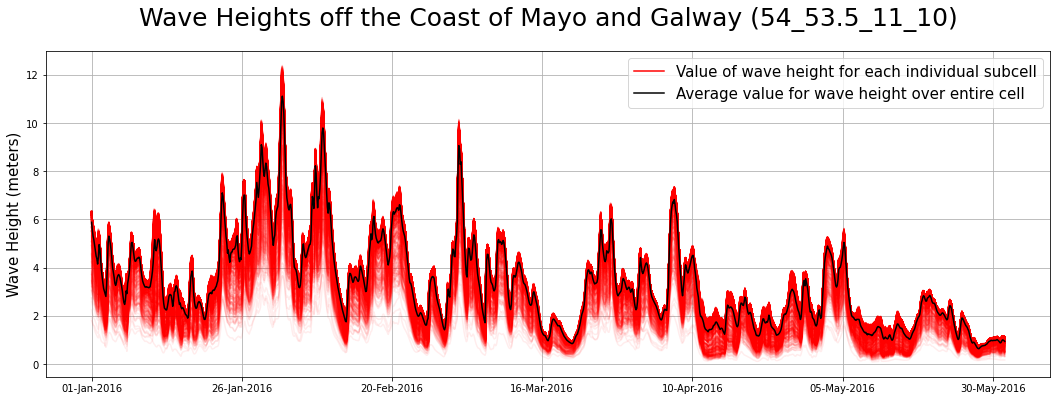

In [28]:
data = xr.open_dataset(str(cur_dir) + "/gis_data/MetO-NWS-WAV-RAN_54_53.5_11_10.nc")
make_plot("2016-01-01T00:00:00.000000000", "2016-06-01T00:00:00.000000000")
plt.grid()
plt.ylabel("Wave Height (meters)", size = 15)
plt.title("Wave Heights off the Coast of Mayo and Galway (54_53.5_11_10)", size = 25, pad = 25)
plt.show()

In [29]:
'''data = xr.open_dataset(str(cur_dir) + "/gis_data/MetO-NWS-WAV-RAN_53_52.5_6.5_5.5.nc")
make_plot("2016-01-01T00:00:00.000000000", "2016-05-01T00:00:00.000000000")
plt.ylabel("Wave Height (meters)", size = 15)
plt.grid()
plt.title("Wave Heights off the East coast (53_52.5_6.5_5.5)", size = 25, pad = 25)
plt.show()'''

'data = xr.open_dataset(str(cur_dir) + "/gis_data/MetO-NWS-WAV-RAN_53_52.5_6.5_5.5.nc")\nmake_plot("2016-01-01T00:00:00.000000000", "2016-05-01T00:00:00.000000000")\nplt.ylabel("Wave Height (meters)", size = 15)\nplt.grid()\nplt.title("Wave Heights off the East coast (53_52.5_6.5_5.5)", size = 25, pad = 25)\nplt.show()'

<br/><br/><br/><br/>

# Influence of Wave Period on Wave Height

In [30]:

def kfold_regression(data):

    wave_heights = data["VHM0"].mean(dim = "longitude").mean(dim = "latitude").values
    wave_periods = data["VTM10"].mean(dim = "longitude").mean(dim = "latitude").values


    x = wave_periods
    y = wave_heights
    x = x.reshape(-1,1)
    x.shape



    kf = KFold(n_splits = 10, random_state=10, shuffle=True)
    model = linear_model.LinearRegression()
    coefficients = []
    intercept = []
    p_values = []
    pred_error = []
    r2_scores = []

    for train, test in kf.split(x, y):
        x_train, x_test, y_train, y_test = x[train], x[test], y[train], y[test]
        model.fit(x_train, y_train)
        yp = model.predict(x_test)

        r2_scores.append(r2_score(y_test, yp))

        X2 = sm.add_constant(x)
        est = sm.OLS(y, X2).fit()

        coefficients.append(model.coef_)
        intercept.append(model.intercept_)

    #     r2_scores.append(est.rsquared)
        p_values.append(est.pvalues[1])


        pred_error.append((yp - y_test)**2)



    # print("score", np.mean(scores))
    print("r2_score", np.mean(r2_scores))
    print("p-value", max(p_values))
#     print("pred_error", np.mean(pred_error))
    print()
    print("Intercept", np.mean(intercept))
    print("Coefficients", np.mean(coefficients))

In [31]:
data_m3_mod = data_m3.sel(time = slice("2003-01-01T00:00:00.000000000", "2007-12-31T00:00:00.000000000"))

In [32]:

kfold_regression(data_m3_mod)

r2_score 0.49038327567065376
p-value 0.0

Intercept -2.7731519
Coefficients 0.6466202


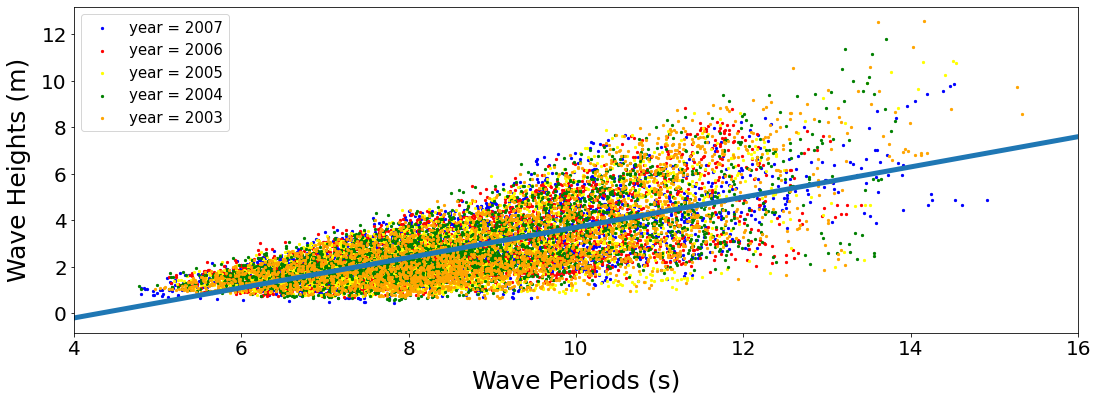

In [33]:
data = data_m3_mod
intercept = -2.8
slope = 0.65

x = [x for x in range(4,19)]
y = []
for val in x:
    y.append(intercept + (slope*val))

years = [x for x in range(2003,2008)]
colors = ["blue", "red", "yellow", "green", "orange", "purple"]
i = -1
for year in years:
    i += 1
    wave_heights = data["VHM0"].sel(time = slice(str(year) + "-01-01T00:00:00.000000000", str(year) + "-12-31T00:00:00.000000000")).mean(dim = "longitude").mean(dim = "latitude").values
    wave_periods = data["VTM10"].sel(time = slice(str(year) + "-01-01T00:00:00.000000000", str(year) + "-12-31T00:00:00.000000000")).mean(dim = "longitude").mean(dim = "latitude").values
    plt.scatter(wave_periods, wave_heights, s = 5, color = colors[i])

#plt.title("Fitted linear model of wave heigts regressed on wave periods (West Coast)", fontsize = 25, pad = 15)
plt.legend(["year = 2007", "year = 2006", "year = 2005", "year = 2004", "year = 2003"], loc = "upper left", fontsize = 15)    
plt.plot(x, y, linewidth = 5)
#plt.ylim([0,12])
plt.xlim([4,16])
plt.ylabel("Wave Heights (m)", size = 25, labelpad = 10)
plt.xlabel("Wave Periods (s)", size = 25, labelpad = 10)
plt.gca().tick_params(axis = "both", labelsize = 20)


<br/><br/><br/><br/>

# Analysis of Data Received from Met Eireann

In [34]:
dfm1 = pd.read_csv(str(cur_dir) + "/buoy_data/hly62090.csv", skiprows = 19) 
dfm2 = pd.read_csv(str(cur_dir) + "/buoy_data/hly62091.csv", skiprows = 19) 
dfm3 = pd.read_csv(str(cur_dir) + "/buoy_data/hly62092.csv", skiprows = 19)
dfm4 = pd.read_csv(str(cur_dir) + "/buoy_data/hly62093.csv", skiprows = 19)
dfm5 = pd.read_csv(str(cur_dir) + "/buoy_data/hly62094.csv", skiprows = 19)

/home/cm/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3172: DtypeWarning: Columns (2,3,4,6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/home/cm/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3172: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/home/cm/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3172: DtypeWarning: Columns (1,7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/home/cm/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3172: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.ru

In [35]:
def df_convert_types(df):

    for col in df.head(0):
        df[col].replace(' ', np.nan, inplace = True)


    df["wavht"] = pd.to_numeric(df["wavht"], errors='coerce')
    df["gust"] = pd.to_numeric(df["gust"], errors='coerce')
    df["wdsp"] = pd.to_numeric(df["wdsp"], errors='coerce')
    df["dir"] = pd.to_numeric(df["dir"], errors='coerce')
    df["wvdir"] = pd.to_numeric(df["wvdir"], errors='coerce')
    df["seatp"] = pd.to_numeric(df["seatp"], errors='coerce')
    df["temp"] = pd.to_numeric(df["temp"], errors='coerce')
    df["per"] = pd.to_numeric(df["per"], errors='coerce')
    df["rhum"] = pd.to_numeric(df["rhum"], errors='coerce')
    df["msl"] = pd.to_numeric(df["msl"], errors='coerce')
    df["mxwave"] = pd.to_numeric(df["mxwave"], errors='coerce')
    
    df["date"] = pd.to_datetime(df["date"])

    df = df.set_index(["date"])
    
    return df

In [36]:
dfm1 = df_convert_types(dfm1)
dfm2 = df_convert_types(dfm2)
dfm3 = df_convert_types(dfm3)
dfm4 = df_convert_types(dfm4)
dfm5 = df_convert_types(dfm5)

In [37]:
dfm1_mod = dfm1.to_csv(str(cur_dir) + '/buoy_data_modified/dfm1_mod.csv')
dfm2_mod = dfm2.to_csv(str(cur_dir) + '/buoy_data_modified/dfm2_mod.csv')
dfm3_mod = dfm3.to_csv(str(cur_dir) + '/buoy_data_modified/dfm3_mod.csv')
dfm4_mod = dfm4.to_csv(str(cur_dir) + '/buoy_data_modified/dfm4_mod.csv')
dfm5_mod = dfm5.to_csv(str(cur_dir) + '/buoy_data_modified/dfm5_mod.csv')

In [38]:
dfm3

,temp,rhum,wdsp,dir,gust,msl,seatp,per,wavht,mxwave,wvdir
date,,,,,,,,,,,
2002-07-22 08:00:00,15.2,90.000,9.000,250.000,16.000,1023.0,15.3,NaN,NaN,NaN,NaN
2002-07-22 09:00:00,15.0,93.000,11.000,260.000,17.000,1022.8,15.2,NaN,NaN,NaN,NaN
2002-07-22 10:00:00,14.9,94.000,11.000,250.000,17.000,1022.8,15.2,NaN,NaN,NaN,NaN
2002-07-22 11:00:00,14.8,95.000,12.000,250.000,17.000,1022.8,15.2,NaN,NaN,NaN,NaN
2002-07-22 12:00:00,14.9,96.000,12.000,250.000,18.000,1022.4,15.2,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2021-11-30 19:00:00,12.1,92.480,22.779,290.742,28.474,1009.3,11.7,6.094,2.6,3.0,277.0
2021-11-30 20:00:00,12.2,83.984,27.791,308.672,37.814,1009.7,11.7,6.562,3.3,5.0,282.7
2021-11-30 21:00:00,11.8,79.395,31.322,309.727,38.156,1010.4,11.6,6.211,3.1,4.3,285.5


In [39]:
def corr_matrix(df):
    r = df.dropna(how = "any", axis = 0)
    r = r.to_numpy()
    r = np.transpose(r)

    r.shape
    corr = np.corrcoef(r)
    corr = np.round(corr, 2)

    mask = np.zeros_like(corr)

    mask[np.triu_indices_from(mask)] = True

    with sn.axes_style("white"):

        f, ax = plt.subplots()
        ax.set_yticklabels(ax.get_yticks(), size = 15)
        ax.set_xticklabels(ax.get_xticks(), size = 15)

        ax = sn.heatmap(corr, mask=mask, square=True, annot = True, 
                        yticklabels = list(df.head(0)), 
                        xticklabels = list(df.head(0)),
                        cmap = "Greens",
                        cbar_kws = {"label": "Correlation"})
        cax = plt.gcf().axes[-1]
        cax.tick_params(labelsize=20)

/tmp/ipykernel_5939/940053283.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), size = 15)
/tmp/ipykernel_5939/940053283.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), size = 15)


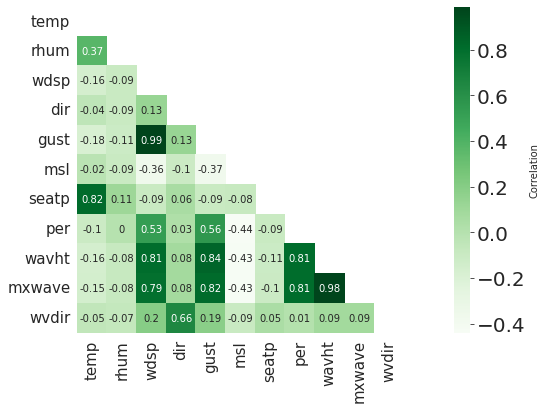

In [40]:
#plt.rcParams["axes.labelsize"] = 30
#plt.rcParams["figure.figsize"] = (18, 14)

corr_matrix(dfm2)

/tmp/ipykernel_5939/940053283.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), size = 15)
/tmp/ipykernel_5939/940053283.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), size = 15)


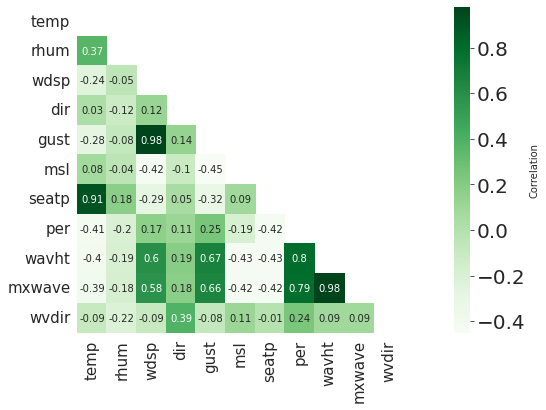

In [41]:
corr_matrix(dfm3)

/tmp/ipykernel_5939/940053283.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), size = 15)
/tmp/ipykernel_5939/940053283.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), size = 15)


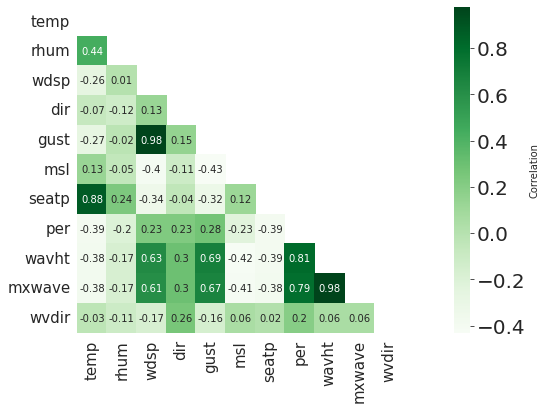

In [42]:
corr_matrix(dfm4)

/tmp/ipykernel_5939/940053283.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), size = 15)
/tmp/ipykernel_5939/940053283.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), size = 15)


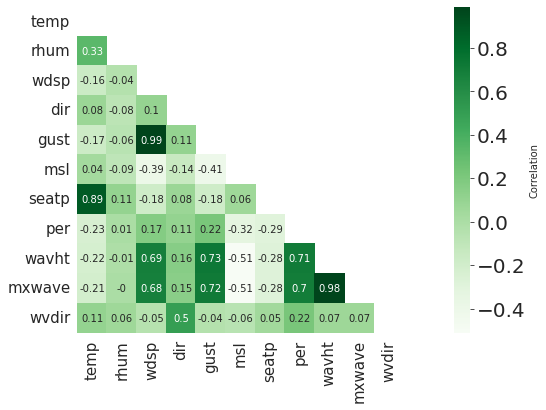

In [43]:
corr_matrix(dfm5)

In [44]:
percentage = dfm2.isnull().sum(0)/len(dfm2)
df_temp = pd.DataFrame(round(percentage*100, 2))



df_names = ["M3", "M4", "M5"]
df_list = [dfm3, dfm4, dfm5]
# df_temp.style.set_caption("% Missing data at each buoy")
for i in range(len(df_list)):
    percentage = df_list[i].isnull().sum(0)/len(df_list[i])
    percentage = round(percentage*100, 2)
    df_temp.insert(1, df_names[i], percentage)


df_temp.rename(columns = {0:'M2'}, inplace = True)
df_temp


,M2,M5,M4,M3
temp,0.00,3.73,2.47,0.31
rhum,11.31,7.85,27.76,3.85
wdsp,1.33,5.18,8.80,8.65
dir,2.04,5.31,3.80,2.54
gust,3.95,6.25,10.49,12.40
msl,0.83,0.82,6.21,2.56
seatp,13.85,1.29,3.83,6.29
per,13.58,11.65,28.94,6.03
wavht,13.60,11.69,28.94,6.03
mxwave,63.21,56.46,68.52,63.23


In [45]:
dfm3[["wdsp"]].isna().sum(0)/len(dfm3)

wdsp    0.08646
dtype: float64

In [46]:
df = dfm3[["wdsp"]]
df = df[(df.index.year >= 2003) & (df.index.year <= 2009)]
(df.isna()).sum(0)/len(df) * 100

wdsp    12.111093
dtype: float64

In [47]:
df = dfm3[["wdsp"]]

for y in range(2003,2011):
    print((df[(df.index.year == y)].isna().sum(0))/len(df[(df.index.year == y)]) * 100)


wdsp    0.313953
dtype: float64
wdsp    20.848643
dtype: float64
wdsp    0.0
dtype: float64
wdsp    18.647588
dtype: float64
wdsp    0.0
dtype: float64
wdsp    44.733242
dtype: float64
wdsp    0.0
dtype: float64
wdsp    0.0
dtype: float64


In [48]:
df_list = [dfm2, dfm3, dfm4, dfm5]
df_names = ["M2", "M3", "M4", "M5"]


missing = []
for df in df_list:
    missing_vals = len(
        pd.date_range(start = df.index[0], 
                      end = df.index[-1], 
                      freq = "H").difference(df.index))
    missing_vals = round((missing_vals/len(df)) * 100, 2)
    missing.append(missing_vals)

for i in range(len(missing)):
    print(df_names[i], missing[i])

M2 17.4
M3 23.92
M4 11.54
M5 10.33


In [49]:
def monthly_missing_values(year, df):


    full_year = pd.date_range(
            start = str(year) + "-01-01 00:00:00",
            end = str(year) + "-12-31 00:00:00",
            freq = "H")

    table_vals = df[df.index.year == year].index

    months_missing = []
    count = 0
    for elem in full_year:
        if elem not in table_vals:
            count += 1
            months_missing.append(elem.month)


    map1 = {}
    prev = 0
    count = 0

    months = ["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]
    for elem in months_missing:
        if elem == prev:
            count += 1
            map1[months[elem-1]] = count

        else:
            count = 1
            map1[months[elem-1]] = count
            prev = elem



    full_month = pd.date_range(
            start = str(year) + "-01-01 00:00:00",
            end = str(year) + "-12-31 00:00:00",
            freq = "H")

    map2 = {}
    for m in map1.keys():
        start = str(year) + "-" + str(m) + "-01 00:00:00"
        start = pd.to_datetime(start)

        full_month = pd.date_range(
            start = str(year) + "-" + str(m) + "-01 00:00:00",
            end = str(year) + "-" + str(m) + "-" + str(start.days_in_month) +  " 23:00:00",
            freq = "H")

        map2[m] = [round(((map1[m]/len(full_month)) * 100), 2)]

    map2
    df_temp = pd.DataFrame(map2)
    return np.transpose(df_temp)

In [50]:
def heat_map_all_missing_values(df, var):

    a = monthly_missing_values(df.index.year[0] - 1, df)
    for y in range(df.index.year[0] - 1, df.index.year[-1] + 1):
        b = monthly_missing_values(y, df)
        a.insert(0, str(y), b)

    a.drop(a.columns[len(a.columns)-1], axis=1, inplace=True)

    for col in a.head(0):
        a[col].replace(np.nan, 0, inplace = True)

    for col in a.head(0):
        a[col].replace(np.nan, 0, inplace = True)




    for y in a.columns:
        alist = []
        for m in range(1,13):
            start = str(y) + "-" + str(m) + "-01 00:00:00"
            start = pd.to_datetime(start)


            full_month = pd.date_range(
                start = str(y) + "-" + str(m) + "-01 00:00:00",
                end = str(y) + "-" + str(m) + "-" + str(start.days_in_month) +  " 23:00:00",
                freq = "H")
            val = sum(df[(df.index.year == int(y)) & (df.index.month == m)][str(var)].isna())/len(full_month)*100
            alist.append(round(val,2))

        a[str(y)] = a[str(y)] + alist
    alist

    # a[a.columns[-1]] = a[a.columns[-1]] + t
    # int(a.columns[0])

    b = a.to_numpy()

    months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

    x_labels = [x for x in range(df.index.year[0] - 1, df.index.year[-1] + 1)]
    x_labels.reverse()


    hm = sn.heatmap(data = b, cmap = "YlOrRd", xticklabels = x_labels, 
                    yticklabels = months, cbar_kws = {"label": "% of " + str(var) + " values missing for each month"})

    hm.set_yticklabels(hm.get_ymajorticklabels(), fontsize = 13)
    hm.set_xticklabels(hm.get_xmajorticklabels(), fontsize = 11)


    for _, spine in hm.spines.items():

        spine.set_visible(True)
        spine.set_linewidth(3)
        cax = plt.gcf().axes[-1]
        cax.tick_params(labelsize=12)


In [51]:
df = dfm2
a = monthly_missing_values(1999, df)
for y in range(1999, 2022):
    b = monthly_missing_values(y, df)
    a.insert(0, str(y), b)

a.drop(a.columns[len(a.columns)-1], axis=1, inplace=True)

In [52]:
dftemp = dfm2[["wdsp"]]
df = dftemp[(dftemp.index.year == 2005)]
df.isna().sum(0)

wdsp    0
dtype: int64

In [53]:
dfm2[1:5]

,temp,rhum,wdsp,dir,gust,msl,seatp,per,wavht,mxwave,wvdir
date,,,,,,,,,,,
2001-05-03 15:00:00,8.7,71.0,9.0,360.0,12.0,1014.6,8.9,4.0,1.0,NaN,NaN
2001-05-03 16:00:00,8.8,76.0,8.0,350.0,12.0,1014.2,8.7,5.0,1.0,NaN,NaN
2001-05-03 17:00:00,8.8,77.0,9.0,360.0,12.0,1014.2,8.7,5.0,0.8,NaN,NaN
2001-05-03 18:00:00,8.9,80.0,8.0,360.0,11.0,1014.0,8.6,5.0,0.8,NaN,NaN


In [54]:
for col in a.head(0):
    a[col].replace(np.nan, 0, inplace = True)
a

,2021,2020,2019,2018,2017,2016,2015,2014,2013,2012,...,2008,2007,2006,2005,2004,2003,2002,2001,2000,1999
jan,0.00,0.00,0.00,98.52,0.00,2.82,0.00,0.00,4.84,0.00,...,0.54,0.00,0.00,3.36,6.85,0.27,0.00,100.00,100.00,100.00
feb,0.00,0.43,2.53,90.92,0.30,0.43,0.00,99.70,0.45,0.00,...,0.00,0.00,0.45,0.00,0.00,0.60,0.00,100.00,100.00,100.00
mar,0.27,0.00,45.30,0.00,0.00,0.40,0.27,100.00,0.00,0.00,...,0.00,0.00,3.09,0.00,0.13,0.40,0.00,100.00,100.00,100.00
apr,0.42,0.00,100.00,0.14,0.28,0.00,1.81,100.00,0.97,1.11,...,0.00,0.00,5.28,9.03,0.97,0.00,0.00,100.00,100.00,100.00
may,1.08,0.00,100.00,0.81,0.00,0.54,0.13,100.00,1.88,0.00,...,0.81,0.00,1.21,0.00,1.08,2.28,0.00,8.47,100.00,100.00
jun,0.42,0.14,100.00,98.06,0.00,0.14,0.00,100.00,0.14,0.00,...,1.11,0.00,0.00,0.00,0.00,0.00,0.69,0.69,100.00,100.00
jul,0.00,0.00,47.58,100.00,0.00,2.82,0.54,81.99,11.83,0.54,...,0.81,3.09,0.00,1.08,35.75,0.00,0.40,0.67,100.00,100.00
aug,0.40,0.54,0.54,100.00,0.00,0.40,0.13,1.21,88.71,0.00,...,0.00,0.00,0.00,0.00,41.94,1.75,0.00,0.00,100.00,100.00
sep,0.28,0.28,0.00,100.00,0.14,1.11,0.42,0.00,0.42,0.69,...,0.42,0.00,0.42,0.28,1.11,0.00,0.00,0.00,100.00,100.00
oct,0.00,0.40,0.00,27.28,0.00,6.85,0.00,0.00,0.40,0.13,...,0.00,1.88,74.33,1.88,2.28,1.34,0.00,0.00,100.00,100.00


In [55]:
def heat_map_skipped_rows(df):

    plt.rcParams["axes.labelsize"] = 15
    a = monthly_missing_values(df.index.year[0] - 1, df)
    for y in range(df.index.year[0] - 1, df.index.year[-1] + 1):
        b = monthly_missing_values(y, df)
        a.insert(0, str(y), b)

    a.drop(a.columns[len(a.columns)-1], axis=1, inplace=True)

    for col in a.head(0):
        a[col].replace(np.nan, 0, inplace = True)

    for col in a.head(0):
        a[col].replace(np.nan, 0, inplace = True)

    b = a.to_numpy()

    months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

    x_labels = [x for x in range(df.index.year[0] - 1, df.index.year[-1] + 1)]
    x_labels.reverse()


    hm = sn.heatmap(data = b, cmap = "YlOrRd", xticklabels = x_labels, 
                    yticklabels = months, cbar_kws = {"label": "% of rows missing for each month"})

    hm.set_yticklabels(hm.get_ymajorticklabels(), fontsize = 13)
    hm.set_xticklabels(hm.get_xmajorticklabels(), fontsize = 11)


    for _, spine in hm.spines.items():

        spine.set_visible(True)
        spine.set_linewidth(3)
        cax = plt.gcf().axes[-1]
        cax.tick_params(labelsize=12)
    

### Rows that are skipped in the time series for every year at buoy M2

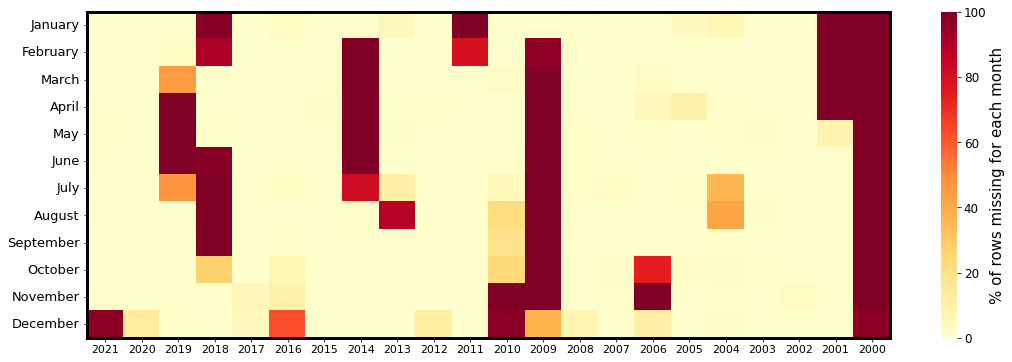

In [56]:
heat_map_skipped_rows(dfm2)

/tmp/ipykernel_5939/940053283.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), size = 15)
/tmp/ipykernel_5939/940053283.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), size = 15)


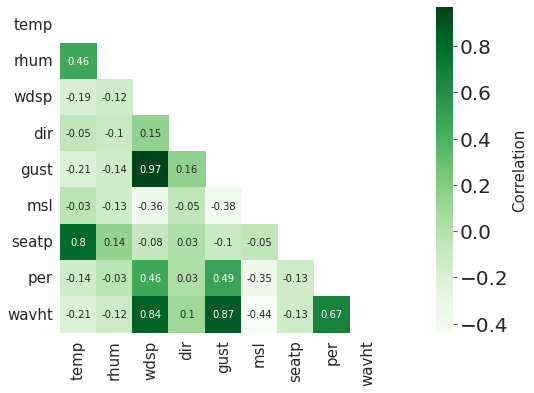

In [57]:
df_temp = dfm2[(dfm2.index.year >= 2002) & (dfm2.index.year <= 2005)]
del df_temp["mxwave"]
del df_temp["wvdir"]
df_temp
corr_matrix(df_temp)


<br/><br/><br/><br/>

### Rows that are skipped in the time series for every year at buoy M3

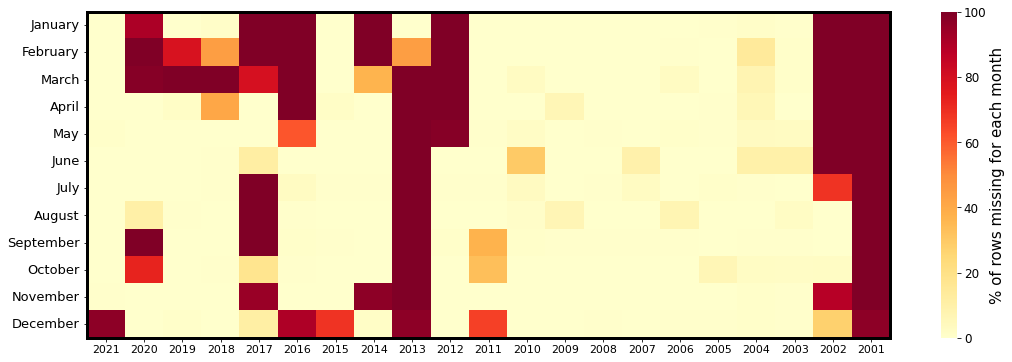

In [58]:
heat_map_skipped_rows(dfm3)

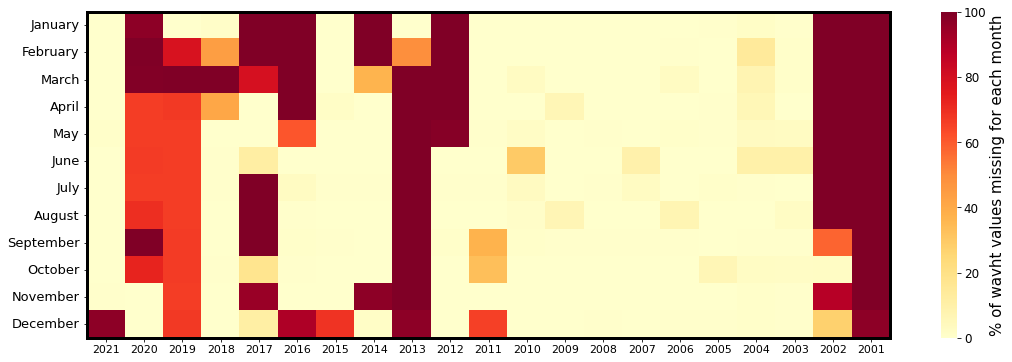

In [59]:
heat_map_all_missing_values(dfm3, "wavht")

/tmp/ipykernel_5939/940053283.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), size = 15)
/tmp/ipykernel_5939/940053283.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), size = 15)


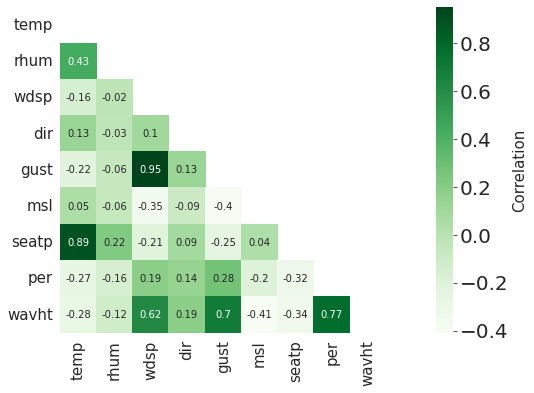

In [60]:
df_temp = dfm3[(dfm3.index.year >= 2003) & (dfm3.index.year <= 2010)]
del df_temp["mxwave"]
del df_temp["wvdir"]
df_temp
corr_matrix(df_temp)


<br/><br/><br/><br/>

### Rows that are skipped in the time series for every year at buoy M4

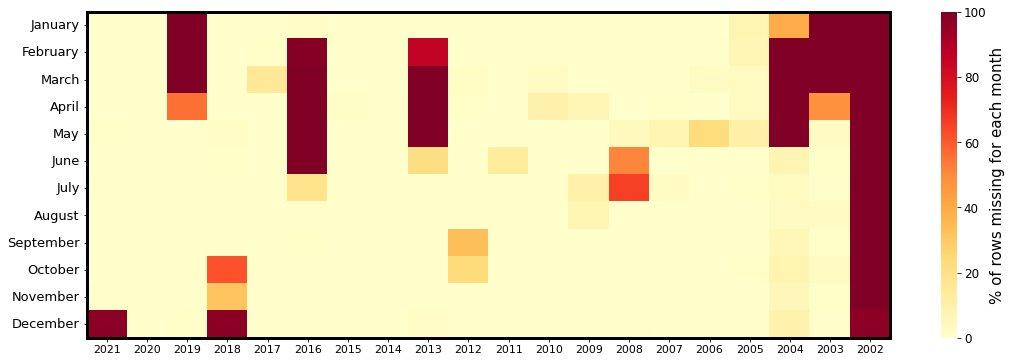

In [61]:
heat_map_skipped_rows(dfm4)

<br/><br/><br/><br/>

### Rows that are skipped in the time series for every year at buoy M5

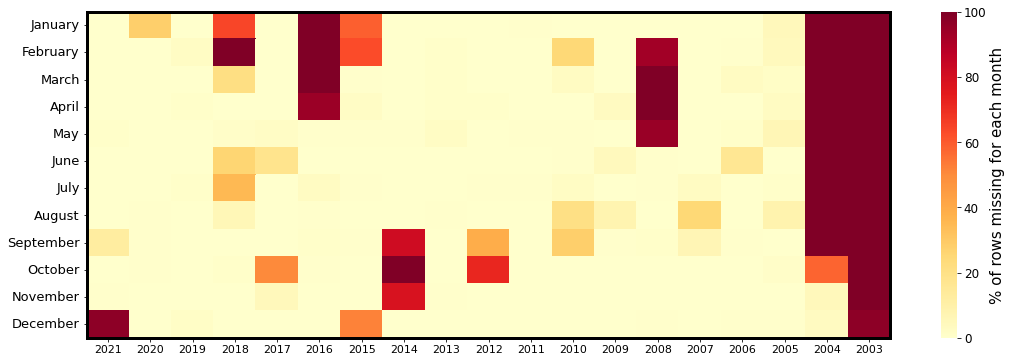

In [62]:
heat_map_skipped_rows(dfm5)

<br/><br/><br/><br/>

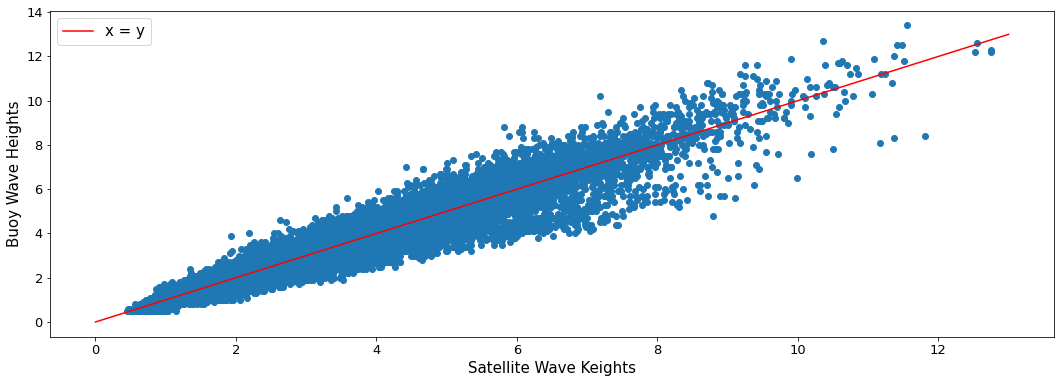

In [63]:
wave_heights = data_m3["VHM0"].mean(dim = "longitude").mean(dim = "latitude").values
time = data_m3["time"].values
wave_period = data_m3["VTPK"].mean(dim = "longitude").mean(dim = "latitude").values

map1 = {"time": time, "wave_height": wave_heights, "wave_period": wave_period}
nc_df3 = pd.DataFrame(map1)
nc_df3 = nc_df3.set_index(["time"])

df_hybrid = nc_df3.join(dfm3)
df_hybrid = df_hybrid[df_hybrid.index.year >= 2002]
df_hybrid
x = [x for x in range(0,14)]
plt.plot(x,x, color = "red")
plt.scatter(df_hybrid["wave_height"], df_hybrid["wavht"])
plt.ylabel("Buoy Wave Heights", fontsize = 15)
plt.xlabel("Satellite Wave Keights", fontsize = 15)
plt.legend(["x = y"], loc = "upper left", fontsize = 15)    
plt.gca().tick_params(axis = "both", labelsize = 13)


In [64]:
np.sum((df_hybrid["wave_height"] - df_hybrid["wavht"])**2)

7280.018725689728

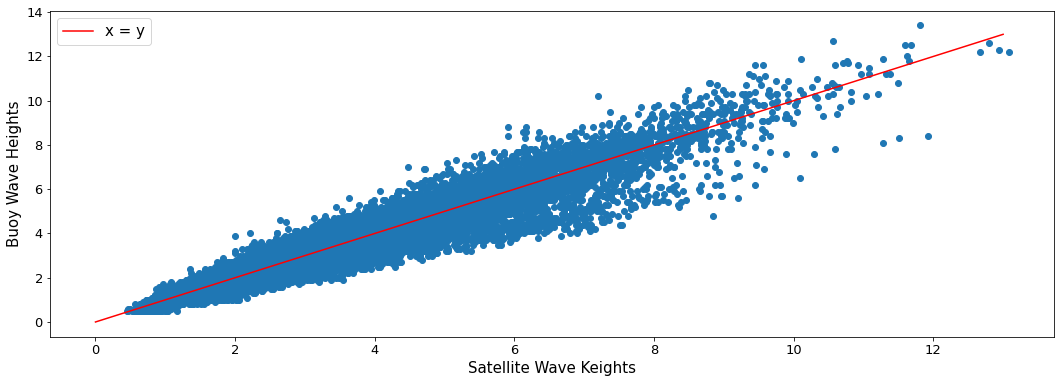

In [65]:
wave_heights = data_m3["VHM0"].sel(longitude = -10.545455, latitude = 51.22973).values
time = data_m3["time"].values
wave_period = data_m3["VTPK"].mean(dim = "longitude").mean(dim = "latitude").values

map1 = {"time": time, "wave_height": wave_heights, "wave_period": wave_period}
nc_df3 = pd.DataFrame(map1)
nc_df3 = nc_df3.set_index(["time"])

df_hybrid = nc_df3.join(dfm3)
df_hybrid = df_hybrid[df_hybrid.index.year >= 2002]
df_hybrid
x = [x for x in range(0,14)]
plt.plot(x,x, color = "red")
plt.scatter(df_hybrid["wave_height"], df_hybrid["wavht"])
plt.ylabel("Buoy Wave Heights", fontsize = 15)
plt.xlabel("Satellite Wave Keights", fontsize = 15)
plt.legend(["x = y"], loc = "upper left", fontsize = 15)    
plt.gca().tick_params(axis = "both", labelsize = 13)


In [66]:
np.sum((df_hybrid["wave_height"] - df_hybrid["wavht"])**2)

7249.176087231325

In [67]:
np.sum(abs(df_hybrid["wave_height"] - df_hybrid["wavht"]))/len(df_hybrid)

0.21752247881571551

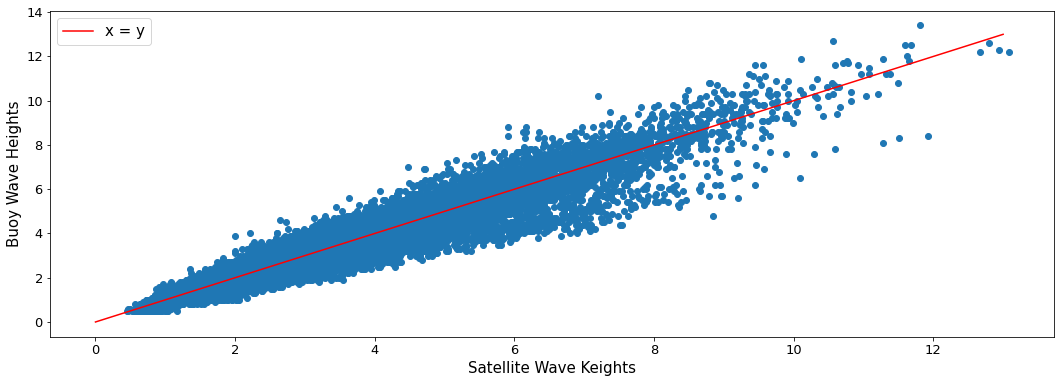

In [68]:
wave_heights = data_m3["VHM0"].sel(longitude = -10.545455, latitude = 51.22973).values
time = data_m3["time"].values
wave_period = data_m3["VTPK"].mean(dim = "longitude").mean(dim = "latitude").values

map1 = {"time": time, "wave_height": wave_heights, "wave_period": wave_period}
nc_df3 = pd.DataFrame(map1)
nc_df3 = nc_df3.set_index(["time"])

df_hybrid = nc_df3.join(dfm3)
df_hybrid = df_hybrid[df_hybrid.index.year >= 2002]
df_hybrid
x = [x for x in range(0,14)]
plt.plot(x,x, color = "red")
plt.scatter(df_hybrid["wave_height"], df_hybrid["wavht"])
plt.ylabel("Buoy Wave Heights", fontsize = 15)
plt.xlabel("Satellite Wave Keights", fontsize = 15)
plt.legend(["x = y"], loc = "upper left", fontsize = 15)    
plt.gca().tick_params(axis = "both", labelsize = 13)


# Regression using variables taken from Met Eireann Dataset

In [69]:
locations = {
    "Galway/Mayo Coast": "_54_53.5_11_10.nc",
    "M1": "_53.5_53_12_11.nc",
    "M2": "_53.5_53_5.5_4.5.nc",
    "M3": "_51.5_51_11_10.nc",
    "M4": "_55.5_55_10_9.nc",
    "M5": "_52_51.5_7_6.nc"
     }

#m2 = locations["M2"]
#data_m2 = xr.open_dataset(str(cur_dir) + "/gis_data/MetO-NWS-WAV-RAN" + str(m2))

m3 = locations["M3"]
data_m3 = xr.open_dataset(str(cur_dir) + "/gis_data/MetO-NWS-WAV-RAN" + str(m3))

#m4 = locations["M4"]
#data_m4 = xr.open_dataset(str(cur_dir) + "/gis_data/MetO-NWS-WAV-RAN" + str(m4))

#m5 = locations["M5"]
#data_m5 = xr.open_dataset(str(cur_dir) + "/gis_data/MetO-NWS-WAV-RAN" + str(m5))

In [70]:
wave_heights = data_m3["VHM0"].mean(dim = "longitude").mean(dim = "latitude").values
time = data_m3["time"].values
wave_period = data_m3["VTM10"].mean(dim = "longitude").mean(dim = "latitude").values

map1 = {"time": time, "wave_height": wave_heights, "wave_period": wave_period}
nc_df3 = pd.DataFrame(map1)
nc_df3 = nc_df3.set_index(["time"])


In [71]:
df_hybrid = nc_df3.join(dfm3)
df_hybrid = df_hybrid[df_hybrid.index.year >= 2003]

In [72]:
df_hybrid

,wave_height,wave_period,temp,rhum,wdsp,dir,gust,msl,seatp,per,wavht,mxwave,wvdir
time,,,,,,,,,,,,,
2003-01-01 00:00:00,3.987033,10.489914,12.3,92.000,15.000,200.000,22.000,993.0,11.5,8.000,3.6,NaN,NaN
2003-01-01 03:00:00,4.006629,10.127345,12.5,90.000,18.000,220.000,25.000,991.2,11.5,8.000,3.8,NaN,NaN
2003-01-01 06:00:00,3.987407,10.186679,12.2,91.000,12.000,220.000,19.000,990.0,11.5,8.000,3.4,NaN,NaN
2003-01-01 09:00:00,4.076780,10.704604,11.7,94.000,9.000,180.000,15.000,988.0,11.4,9.000,3.7,NaN,NaN
2003-01-01 12:00:00,4.281366,11.314898,11.7,90.000,13.000,280.000,20.000,989.4,11.4,9.000,3.9,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 09:00:00,2.244093,9.261905,10.9,90.234,12.813,76.641,16.088,NaN,10.6,7.734,2.7,4.8,286.9
2019-12-31 12:00:00,2.210745,9.280750,10.8,91.406,10.820,63.984,15.518,NaN,10.6,7.500,2.6,3.6,282.7
2019-12-31 15:00:00,2.189260,9.242802,10.9,92.578,11.105,80.859,15.091,NaN,10.5,7.148,2.2,3.8,279.8


In [73]:
def kfold_cv(x, y):
    model = linear_model.LinearRegression()
    p_values = []
    pred_error = []
    r2_scores = []
    
    kf = KFold(n_splits = 10, random_state = 1, shuffle=True)

    for train, test in kf.split(x, y):
        x_train, x_test, y_train, y_test = x[train], x[test], y[train], y[test]
        model.fit(x_train, y_train)
        yp = model.predict(x_test)

        r2_scores.append(r2_score(y_test, yp))

        X2 = sm.add_constant(x)
        est = sm.OLS(y, X2).fit()

        p_values.append(est.pvalues[1])


        pred_error.append((yp - y_test)**2)
    
    

    print("r2_score", np.mean(r2_scores))
    print("p-value", max(p_values))
#     print("pred_error", np.mean(pred_error))

In [74]:
df = df_hybrid[(df_hybrid.index.year >= 2003) & (df_hybrid.index.year <= 2007)]
df = df_hybrid.dropna()
x = df[["wave_period", "wdsp"]]
y = df["wave_height"]

x = np.array(x)
# x = x.reshape(-1,1)
x.shape

(11322, 2)

In [75]:
kfold_cv(x,y)

r2_score 0.7856109247161825
p-value 0.0


<br/><br/><br/><br/>

# Time Series Analysis

In [76]:
loc = locations["M3"]
data = xr.open_dataset(str(cur_dir) + "/gis_data/MetO-NWS-WAV-RAN" + str(loc))

/tmp/ipykernel_5939/1632365906.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([month_list[x] for x in range(-1, 12)])


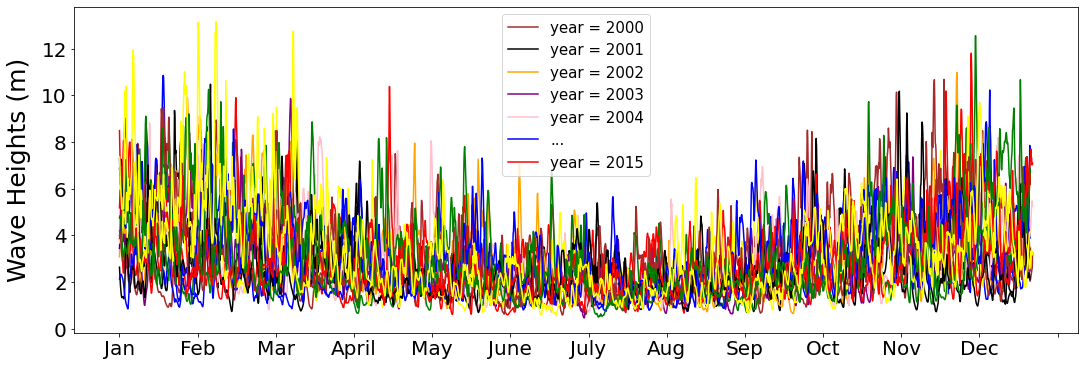

In [77]:
vals = []
fig, ax = plt.subplots()
colours = ["blue", "red", "green", "yellow", "brown", "black", "orange", "purple", "pink",
          "blue", "red", "green", "yellow", "brown", "black"]
for y in range(2000,2015):
    

    t1 = str(y) + "-01-01T00:00:00.000000000"
    t2 = str(y) + "-12-31T00:00:00.000000000"
    d = data.sel(time = slice(t1,t2))

    m = d["VHM0"].mean(dim = "longitude").mean(dim = "latitude").values
    ax.plot(m, color = colours[y-2011])


# print(d["time"].values[-1])    
plt.legend(["year = 2000", "year = 2001", "year = 2002", "year = 2003", "year = 2004", "...", "year = 2015"], loc = "upper center", fontsize = 15)    


plt.ylabel("Wave Heights (m)", size = 25, labelpad = 10)
# plt.title("Wave heights over an entire year at buoy M3", size = 25, pad = 20)


plt.locator_params(axis = 'x', nbins = 13)
month_list = ["Jan", "Feb", "Mar", "April", "May", "June", "July", "Aug", "Sep", "Oct", "Nov", "Dec"]
plt.gca().set_xticklabels([month_list[x] for x in range(-1, 12)])
plt.gca().tick_params(axis = "both", labelsize = 20)


/tmp/ipykernel_5939/3212070742.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([month_list[x] for x in range(-1, 12)])


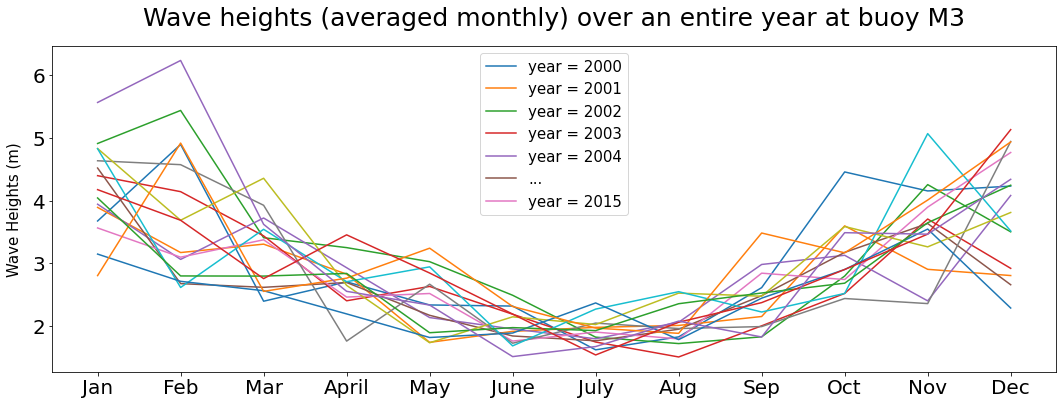

In [78]:
map1 = {}
y1 = 2000
y2 = 2015

for y in range(y1,y2):

    t1 = str(y) + "-01-01T00:00:00.000000000"
    t2 = str(y) + "-12-31T00:00:00.000000000"

    d = data.sel(time = slice(t1,t2))
    monthly_avg = d["VHM0"].groupby("time.month")
    
    vals = []
    for avg in range(1,len(monthly_avg)+1):
        vals.append(np.mean(monthly_avg[avg].mean(dim = "longitude").mean(dim = "latitude").values))

    map1[pd.to_datetime(t1)] = vals

df_temp = pd.DataFrame(map1)
# df_temp = np.transpose(df_temp)

for y in range(y1,y2):
    plt.plot(df_temp[str(y) + "-01-01"])


    

plt.title("Wave heights (averaged monthly) over an entire year at buoy M3", size = 25, pad = 20)

    
plt.legend(["year = 2000", "year = 2001", "year = 2002", "year = 2003", "year = 2004", "...", "year = 2015"], loc = "upper center", fontsize = 15)    
plt.ylabel("Wave Heights (m)", size = 15, labelpad = 10)

plt.locator_params(axis = 'x', nbins = 13)
month_list = ["Jan", "Feb", "Mar", "April", "May", "June", "July", "Aug", "Sep", "Oct", "Nov", "Dec"]
plt.gca().set_xticklabels([month_list[x] for x in range(-1, 12)])
plt.gca().tick_params(axis = "both", labelsize = 20)

In [79]:
time = data["time"].values
wave_heights = data["VHM0"].mean(dim = "longitude").mean(dim = "latitude")
wave_periods = data["VTM10"].mean(dim = "longitude").mean(dim = "latitude").values

map1 = {"time": time, "wave_heights": wave_heights}
df = pd.DataFrame(map1)

map1 = {"time": time, "wave_periods": wave_periods}
df_wp = pd.DataFrame(map1)



months = []
wh_vals = []
wp_vals = []
for y in range(2000,2020):
    for m in range(1,13):
        wh = np.mean((df.loc[(df["time"].dt.year == y) & (df["time"].dt.month == m)])["wave_heights"])
        wp = np.mean((df_wp.loc[(df_wp["time"].dt.year == y) & (df_wp["time"].dt.month == m)])["wave_periods"])
        wh_vals.append(wh)
        wp_vals.append(wp)
        a = dt.datetime(y, m, 1)
        months.append(pd.to_datetime(a))

map1 = {"time": months, "wave_heights": wh_vals}
map2 = {"time": months, "wave_periods": wp_vals}

df2 = pd.DataFrame(map1)
df3 = pd.DataFrame(map2)


# df_wp = pd.DataFrame({"time": months, "wave_periods": })

df = df.set_index(["time"])
df_monthly = df2.set_index(["time"])

df_wp = df_wp.set_index(["time"])
df_wp_monthly = df3.set_index(["time"])

In [80]:
df_4 = df[(df.index.year >= 2003) & (df.index.year <= 2008)]

# df_monthly_2015 = df_monthly[(df_monthly.index.year >= 2003) & (df_monthly.index.year <= 2007)]
df_monthly_2015 = df_monthly[(df_monthly.index.year <= 2015)]

df_wp_monthly_2015 = df_wp_monthly[df_wp_monthly.index.year <= 2015]

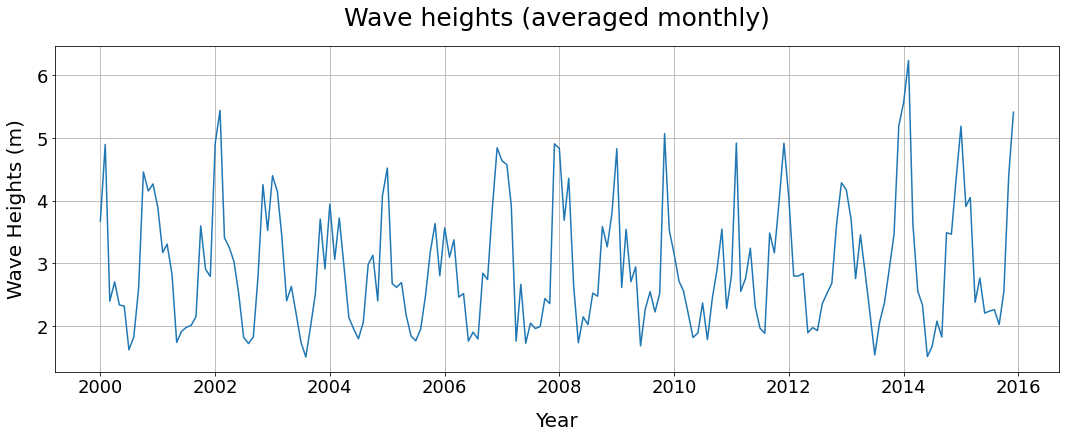

In [81]:
fig, ax = plt.subplots()
plt.plot(df_monthly_2015)
plt.title("Wave heights (averaged monthly)", size = 25, pad = 20)
plt.gca().tick_params(axis = "both", labelsize = 18)

date_form = DateFormatter("%Y")
ax.xaxis.set_major_formatter(date_form)

plt.ylabel("Wave Heights (m)", size = 20, labelpad = 10)
plt.xlabel("Year", size = 20, labelpad = 15)
plt.grid()
# ax.xaxis.set_major_locator(mdates.YearLocator())



In [82]:
from statsmodels.tsa.stattools import adfuller

def test_stationary(ts):
    
    role_mean = ts.rolling(window = 12).mean()
    role_sd = ts.rolling(window = 12).std()
    
    original_data = plt.plot(ts, color = "blue", label = "Original")
    mean_data = plt.plot(role_mean, color = "red", label = "rolling_mean")
    sd_data = plt.plot(role_sd, color = "black", label = "rolling_sd")
    
    plt.legend(loc = "best")
    plt.grid()
    plt.ylabel("Time series of wave heights averaged monthly (m)", size = 20)
    plt.title("Wave heights (averaged monthly)", size = 25, pad = 20)

    plt.xlabel("year", size = 20)
    plt.gca().tick_params(axis = "both", labelsize = 15)
    
    df_test = adfuller(ts, autolag = "AIC")
    df_out = pd.Series(df_test[0:4], index = ["Test Staistic", "p-value", "#Lags-used", "#Observations-used"])
    
    for key, value in df_test[4].items():
        df_out["Critical value " + str(key)] = value
        
    
    print(df_out)

Test Staistic          -3.008368
p-value                 0.034120
#Lags-used             11.000000
#Observations-used    180.000000
Critical value 1%      -3.467211
Critical value 5%      -2.877735
Critical value 10%     -2.575403
dtype: float64


Text(0, 0.5, 'Wave Heights (m)')

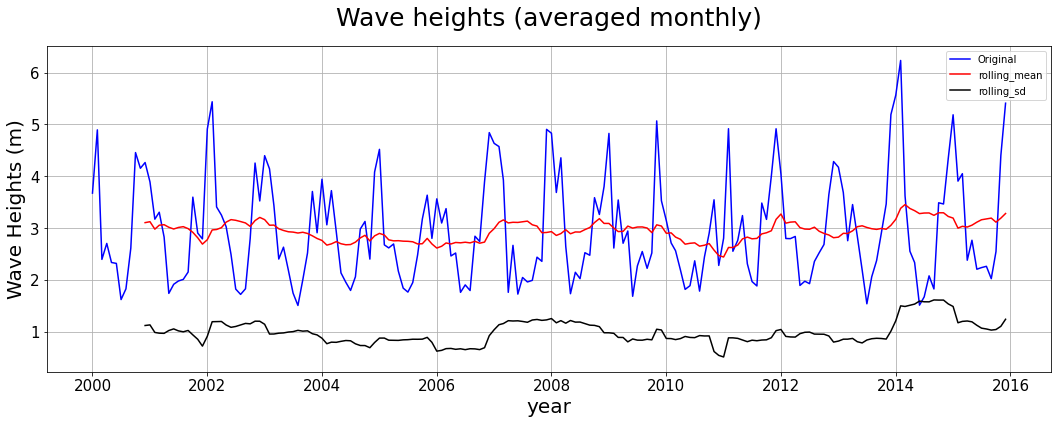

In [83]:
test_stationary(df_monthly_2015)
plt.ylabel("Wave Heights (m)")

In [84]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(df_monthly_2015)
lag_pacf = pacf(df_monthly_2015, method = "ols") #Ordinary least squares method

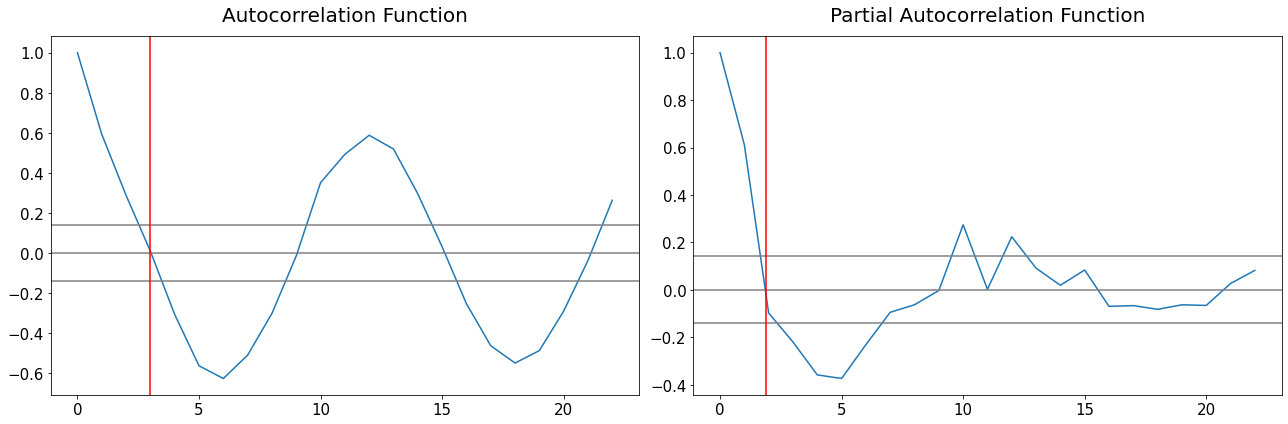

In [85]:
plt.subplot(121)
plt.plot(lag_acf)
sqrt_n = np.sqrt(len(df_monthly_2015))
plt.axhline(y = 1.96/sqrt_n, color = "grey")
plt.axhline(y = -1.96/sqrt_n, color = "grey")
plt.axhline(y = 0, color = "grey")

plt.axvline(x = 3, color = "red")
plt.title("Autocorrelation Function", size = 20, pad = 15)
plt.gca().tick_params(axis = "both", labelsize = 15)



plt.subplot(122)
plt.plot(lag_pacf)
sqrt_n = np.sqrt(len(df_monthly_2015))
plt.axhline(y = 1.96/sqrt_n, color = "grey")
plt.axhline(y = -1.96/sqrt_n, color = "grey")
plt.axhline(y = 0, color = "grey")

plt.axvline(x = 1.9, color = "red")
plt.title("Partial Autocorrelation Function", size = 20, pad = 15)
plt.gca().tick_params(axis = "both", labelsize = 15)

plt.tight_layout()

In [86]:
df_normalized = df_monthly_2015["wave_heights"]/max(df_monthly_2015["wave_heights"])

/home/cm/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/cm/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/cm/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/cm/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Text(0, 0.5, 'Wave Height (m)')

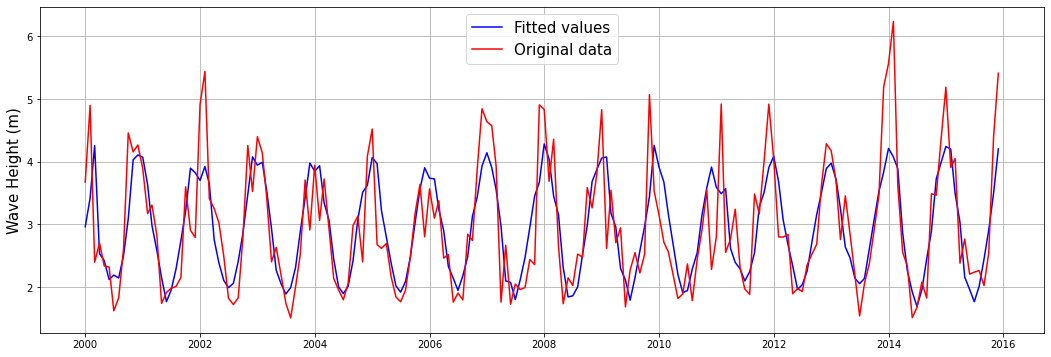

In [87]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df_normalized, order = (2,0,3))

results = model.fit()

plt.plot(results.fittedvalues*max(df_monthly_2015["wave_heights"]), color = "blue")
plt.plot(df_normalized*max(df_monthly_2015["wave_heights"]), color = "red")
plt.ylim = ([1.5, 6])
plt.grid()

plt.legend(["Fitted values", "Original data"], loc = "upper center", fontsize = 15)    

plt.ylabel("Wave Height (m)")

In [88]:
from pmdarima.arima import auto_arima
auto_arima(df_normalized)

ARIMA(order=(2, 0, 3), scoring_args={}, suppress_warnings=True)

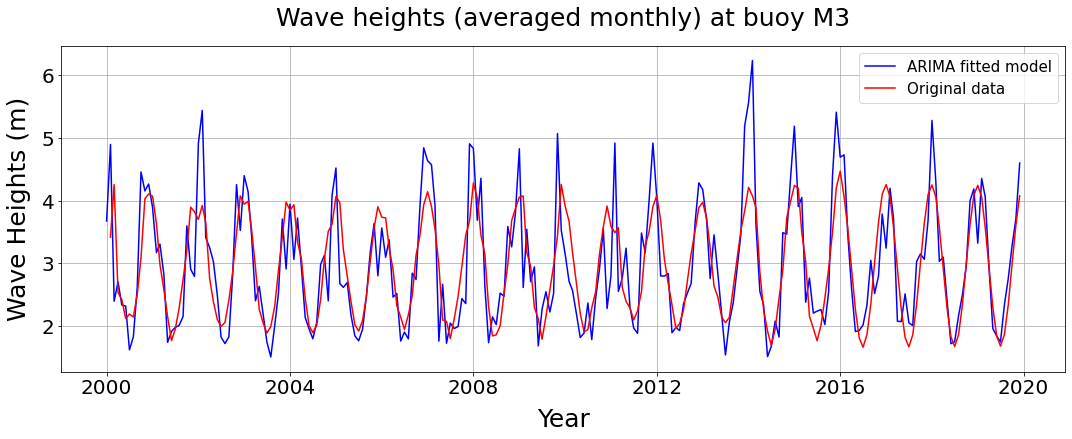

In [89]:
r = results.predict(1, 239)*max(df_monthly_2015["wave_heights"])
plt.plot(df_monthly, color = "blue")
plt.plot(r, color = "red")

plt.title("")
plt.legend(["ARIMA fitted model", "Original data"], loc = "upper right", fontsize = 15)   

plt.gca().tick_params(axis = "both", labelsize = 20)
plt.ylabel("Wave Heights (m)", size = 25, labelpad = 10)
plt.title("Wave heights (averaged monthly) at buoy M3", size = 25, pad = 20)
plt.xlabel("Year", size = 25, labelpad = 10)
plt.grid()

Text(0.5, 1.0, 'Wave heights at buoy M3 (taken over 3 hour intervals)')

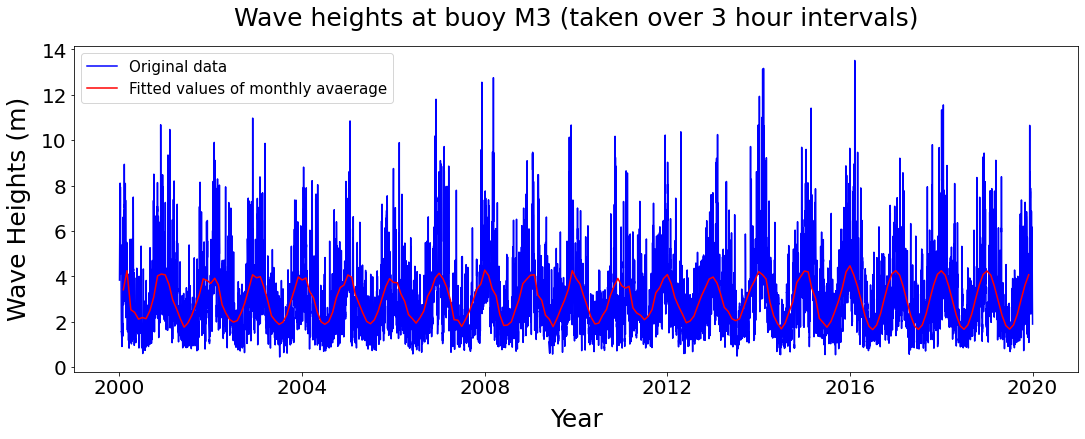

In [90]:
plt.plot(df, color = "blue")
plt.plot(r, color = "red")
plt.legend(["Original data", "Fitted values of monthly avaerage"], loc = "upper left", fontsize = 15)    
plt.ylabel("Wave Heights (m)", size = 25, labelpad = 10)
plt.xlabel("Year", size = 25, labelpad = 10)
plt.gca().tick_params(axis = "both", labelsize = 20)
plt.title("Wave heights at buoy M3 (taken over 3 hour intervals)", size = 25, pad = 20)

In [91]:
predicted = (r["2016-01-01":]).values
observed = df_monthly["2016-01-01":]["wave_heights"].values

np.sqrt(sum((predicted - observed)**2)/len(predicted))

0.45480277011642045

In [92]:
from pmdarima.arima import auto_arima
auto_arima(df_monthly_2015)

ARIMA(order=(2, 0, 2), scoring_args={}, suppress_warnings=True)

In [93]:
exogs = (df_wp_monthly_2015["wave_periods"])

/home/cm/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/cm/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/cm/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


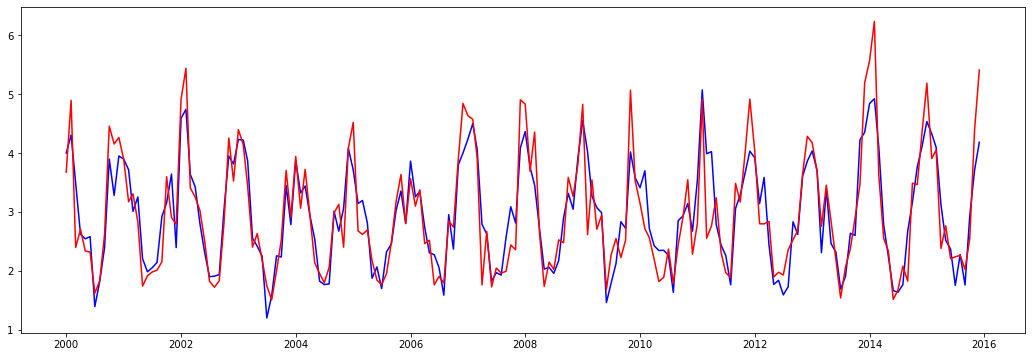

In [94]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df_normalized, order = (2,0,3), exog = exogs)

results = model.fit()
results_f = results.fittedvalues
plt.plot(results_f*max(df_monthly_2015["wave_heights"]), color = "blue")
plt.plot(df_normalized*max(df_monthly_2015["wave_heights"]), color = "red")
plt.ylim = ([1.5, 6])


In [95]:
exogs = df_wp_monthly["2016-01-01":]
len(exogs.values)

48

In [96]:
r = results.forecast(steps = 48, exog = exogs.values)

In [97]:
predicted = r.values * max(df_monthly["wave_heights"])
observed = df_monthly["2016-01-01":]["wave_heights"].values
np.sqrt(sum((predicted - observed)**2)/len(predicted))

0.3716824359912788

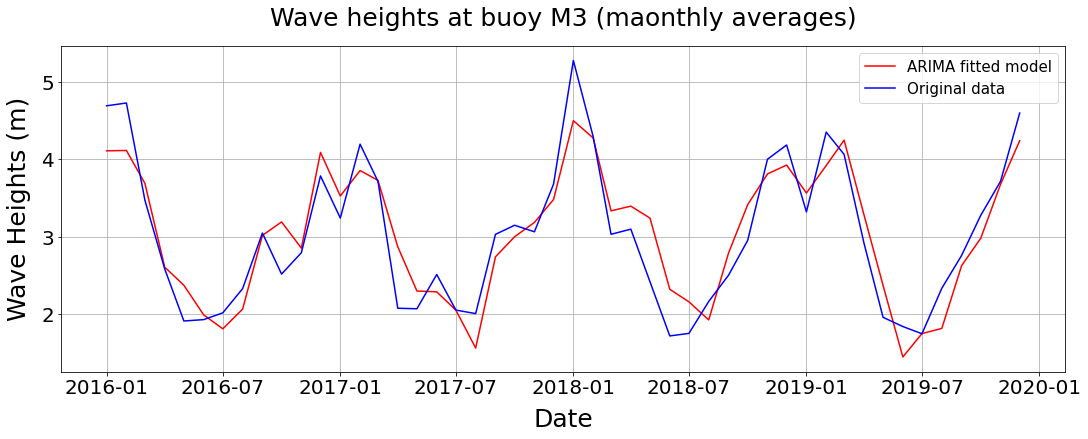

In [98]:
plt.plot(r * max(df_monthly["wave_heights"]), color = "red")
plt.plot(df_monthly["2016-01-01":]["wave_heights"], color = "blue")

plt.ylabel("Wave Heights (m)", size = 25, labelpad = 10)
plt.legend(["ARIMA fitted model", "Original data"], loc = "upper right", fontsize = 15)   

plt.xlabel("Date", size = 25, labelpad = 10)
plt.gca().tick_params(axis = "both", labelsize = 20)
plt.title("Wave heights at buoy M3 (maonthly averages)", size = 25, pad = 20)
plt.grid()

In [99]:
df = df_hybrid[df_hybrid.index.year == 2010]
df["wdsp"].isna().sum()/len(df) * 100

3.184931506849315

In [100]:
df = df_hybrid[["wave_height", "wave_period", "wdsp"]]
df = df[(df.index.year <= 2010) & (df.index.year >= 2003)]
df["wave_height"] = df["wave_height"]/max(df["wave_height"])
df["wdsp"].isna().sum()/len(df)

0.12102156057494866

In [101]:
df

,wave_height,wave_period,wdsp
time,,,
2003-01-01 00:00:00,0.312557,10.489914,15.0
2003-01-01 03:00:00,0.314093,10.127345,18.0
2003-01-01 06:00:00,0.312587,10.186679,12.0
2003-01-01 09:00:00,0.319593,10.704604,9.0
2003-01-01 12:00:00,0.335631,11.314898,13.0
...,...,...,...
2010-12-31 09:00:00,0.156758,7.598978,16.0
2010-12-31 12:00:00,0.157310,8.362638,14.0
2010-12-31 15:00:00,0.156843,9.264118,11.0


/home/cm/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency 3H will be used.
  warnings.warn('No frequency information was'
/home/cm/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency 3H will be used.
  warnings.warn('No frequency information was'
/home/cm/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency 3H will be used.
  warnings.warn('No frequency information was'


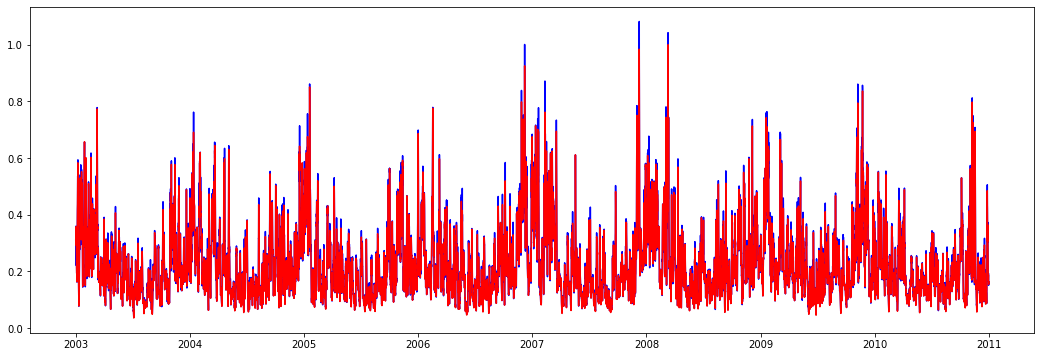

In [102]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df["wave_height"], order = (2,0,3))

results = model.fit()
results_f = results.fittedvalues
plt.plot(results_f*max(df["wave_height"]), color = "blue")
plt.plot(df["wave_height"]*max(df["wave_height"]), color = "red")
plt.ylim = ([1.5, 6])


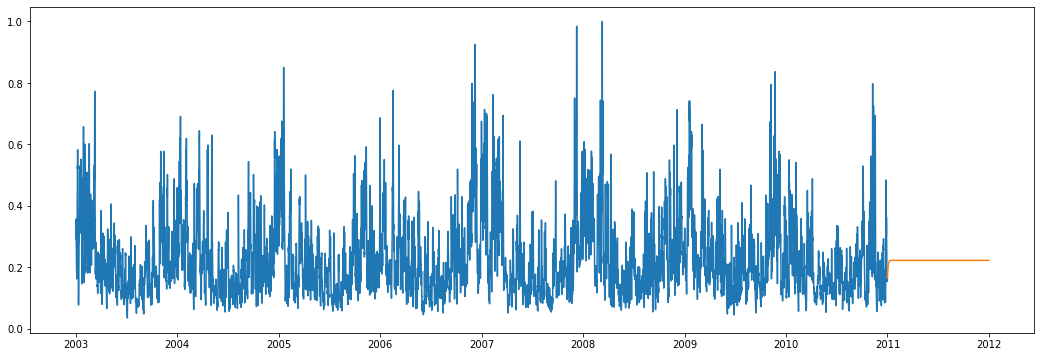

In [103]:
plt.plot(df["wave_height"])
plt.plot(results.forecast(steps = (8*365))*max(df["wave_height"]))


<br/>

### Weekly time series

In [104]:
time = data["time"].values
wave_heights = data["VHM0"].mean(dim = "longitude").mean(dim = "latitude").values
wave_period = data["VTM10"].mean(dim = "longitude").mean(dim = "latitude").values

map1 = {"time": time, "wave_height": wave_heights, "wave_period": wave_period}

df = pd.DataFrame(map1)
df

months = []
vals = []
vals2 = []
for y in range(2000,2015):
    for m in range(1,13):
        wh = np.mean((df.loc[(df["time"].dt.year == y) & (df["time"].dt.month == m)])["wave_height"])
        wp = np.mean((df.loc[(df["time"].dt.year == y) & (df["time"].dt.month == m)])["wave_period"])
        vals.append(wh)
        vals2.append(wp)
        a = dt.datetime(y, m, 1)
        months.append(pd.to_datetime(a))

map1 = {"time": months, "wave_height": vals, "wave_period": vals2} 
df2 = pd.DataFrame(map1)

# df = df.set_index(["time"])
df_monthly = df2.set_index(["time"])
# df = df.set_index(["time"])
df_weekly = df.groupby(pd.Grouper(key='time', axis=0, 
                      freq='7D', sort=True)).mean()


df = df.set_index(["time"])

In [101]:
df_weekly

,wave_height,wave_period
time,,
2000-01-01,5.603977,11.500407
2000-01-08,4.966871,11.063218
2000-01-15,1.402217,7.856342
2000-01-22,2.002824,9.741059
2000-01-29,4.193208,9.512497
...,...,...
2019-11-30,3.049366,9.329137
2019-12-07,6.314649,10.870211
2019-12-14,4.775270,10.853650


Text(0, 0.5, 'Wave Heights (m)')

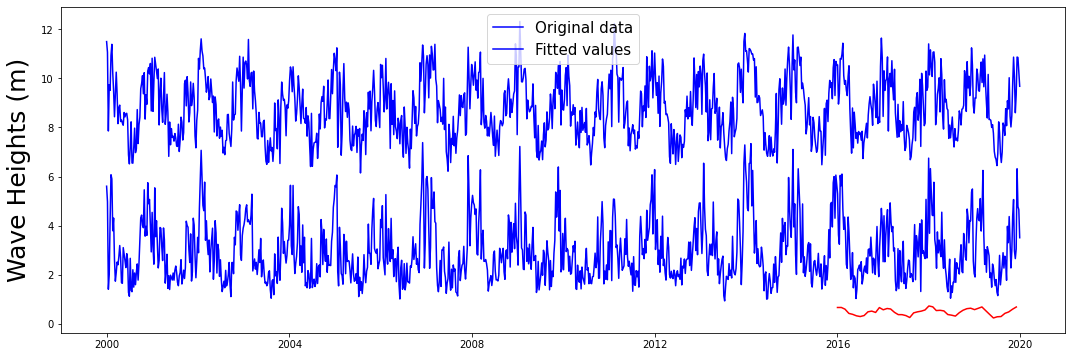

In [102]:
plt.plot(df_weekly, color = "blue")
plt.plot(r, color = "red")
plt.legend(["Original data", "Fitted values"], loc = "upper center", fontsize = 15)    
plt.ylabel("Wave Heights (m)", size = 25, labelpad = 10)
